# IS 6482 - Week 2 — Decision Trees (Classification) with the Telco Churn Dataset

**Author:** Varun Gupta

**Agenda:** fitting decision trees, test-train split  

**Libraries:** `pandas`, `sklearn`, `matplotlib`, `numpy`

**Datasets:** Telco customer churn

---

### Learning goals
By the end of this notebook, you should be able to:

1. **Clean and sanity-check** a real dataset (types, missing values, target variable).
2. Do quick **EDA by the target** (What looks different for churners vs non-churners?).
3. Convert a mixed-type pandas DataFrame into an **all-numeric matrix** that scikit-learn can use (one-hot / dummy encoding).
4. Train decision trees with different **cost-complexity pruning** strengths (`ccp_alpha`).
5. Use the **cost-complexity pruning path** to understand the tradeoff between tree complexity and fit.
6. Illustrate **overfitting** using a train/test split.

**Dataset**: Telco Customer Churn (IBM sample) mirrored as a CSV in a public repo.

In [3]:
# ============================================================
# 0) Imports + plotting defaults (make plots readable in slides)
# ============================================================

import numpy as np
import pandas as pd

# Matplotlib / Seaborn for plots
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for modeling
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Make results reproducible
RANDOM_STATE = 42

## 1) Load the dataset

We'll load the Telco churn dataset from a hosted CSV. In a business setting this might come from a database / data warehouse.

Each row is a customer, and the goal is to predict **`Churn`** (whether the customer left).

In [4]:
# ============================
# Load the Telco churn dataset
# ============================

telco_url = "https://raw.githubusercontent.com/plotly/datasets/master/telco-customer-churn-by-IBM.csv"

# Read the CSV into a pandas DataFrame (table)
churn_df = pd.read_csv(telco_url)

# Quick peek
print("Shape:", churn_df.shape)
churn_df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2) First sanity checks (structure, types, missing values)

Before modeling, always ask:
- What columns do we have?
- Are there missing values?
- Are numeric columns accidentally loaded as strings?

In [5]:
# Basic schema checks
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 3) Minimal cleaning for modeling

We'll do only the cleaning necessary to make the dataset usable for scikit-learn:

1. Drop identifiers (e.g., `customerID`) — these usually do not help prediction.
2. Convert `TotalCharges` to numeric (it often loads as an object/string).
3. Deal with rows where conversion created missing values.

In [6]:
# 1) Drop ID column if present
if "customerID" in churn_df.columns:
    churn_df = churn_df.drop(columns=["customerID"])

# 2) Convert TotalCharges to numeric (invalid parses become NaN)
#    This is common when a column is "mostly numeric" but has blanks.
if "TotalCharges" in churn_df.columns:
    churn_df["TotalCharges"] = pd.to_numeric(churn_df["TotalCharges"], errors="coerce")

# Check what changed
churn_df["TotalCharges"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: TotalCharges
Non-Null Count  Dtype  
--------------  -----  
7032 non-null   float64
dtypes: float64(1)
memory usage: 55.2 KB


In [7]:
# 3) Inspect rows where TotalCharges is missing after conversion
rows_with_nulls = churn_df["TotalCharges"].isna()

print("Rows with TotalCharges missing:", rows_with_nulls.sum())
churn_df.loc[rows_with_nulls, ["tenure", "MonthlyCharges", "TotalCharges", "Churn"]].head(10)

Rows with TotalCharges missing: 11


,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,NaN,No
753,0,20.25,NaN,No
936,0,80.85,NaN,No
1082,0,25.75,NaN,No
1340,0,56.05,NaN,No
3331,0,19.85,NaN,No
3826,0,25.35,NaN,No
4380,0,20.00,NaN,No
5218,0,19.70,NaN,No
6670,0,73.35,NaN,No


In this dataset, missing `TotalCharges` is typically associated with **tenure = 0** (new customers).
For our purposes it is safe to drop these (they are very few, and we know they have not churned since they are still in their first month).

> In a real project you would decide this more carefully (e.g., imputing, adding a missingness indicator, etc.).

In [8]:
# Drop rows with missing TotalCharges
churn_df = churn_df.dropna(subset=["TotalCharges"]).copy()

print("Shape after dropping missing TotalCharges rows:", churn_df.shape)

Shape after dropping missing TotalCharges rows: (7032, 20)


## 4) Separate target (`y`) from features (`X`)

We want:
- `y` = the churn label (True/False)
- `X` = all predictor columns

In [9]:
# Separate the target column
y = churn_df["Churn"].astype(str).str.strip().str.lower()  # normalize strings like " Yes"
y = (y == "yes")                                          # convert to boolean (True = churn)

# A human-friendly version for plots/tables (keeps notebooks readable)
y_label = y.map({False: "No churn", True: "Churn"})

# Drop target from features
X = churn_df.drop(columns=["Churn"])

print("X shape:", X.shape)
print("Churn rate:", y.mean())

X shape: (7032, 19)
Churn rate: 0.26578498293515357


In [10]:
# Convert the columns which should be categorical but are int (SeniorCitizen) or object to category
# First convert Senior Citizen to boolean (True/False) for interpretability later
X["SeniorCitizen"] = (X["SeniorCitizen"] == 1)

# Now convert the object columns and SeniorCitizen to categorical
object_cols = X.select_dtypes(include=["object"]).columns.tolist()
X[["SeniorCitizen"] + object_cols] = X[["SeniorCitizen"] + object_cols].astype("category")
X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   category
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   category
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   category
 16  PaymentMethod     7032 non-nu

# Part A — EDA by the target (before encoding)

Before we create dummy variables, it's useful to do a quick **“What differs by churn?”** check.
This helps students build intuition about which predictors might show up in the decision tree.

We’ll do two things:

1. **Numeric features:** boxplots of numeric variables by churn  
2. **Categorical features:** proportions of category levels by churn

## 5) Numeric features by churn (boxplots)

Boxplots are a quick way to compare distributions across groups.

In [11]:
# Identify numeric columns.
# For boxplots, we focus on "continuous-ish" numeric variables.
all_numeric_cols = X.select_dtypes(include="number").columns.tolist()

all_numeric_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

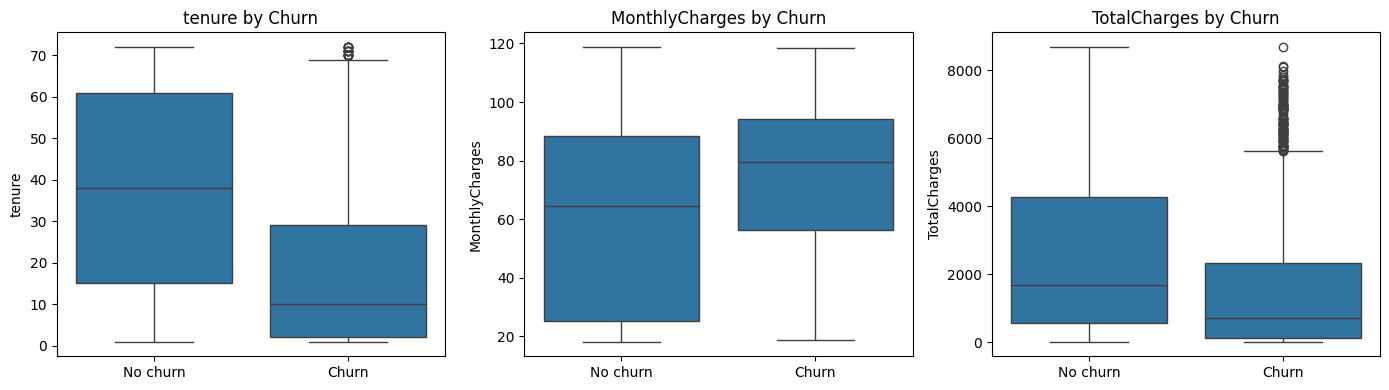

In [12]:
# Boxplots of numeric columns by churn

fig, axes = plt.subplots(1, len(all_numeric_cols), figsize=(14, 4))

for i in range(len(all_numeric_cols)):
    col = all_numeric_cols[i]
    ax = axes[i]
    sns.boxplot(x=y_label, y=X[col], ax=ax)
    ax.set_title(f"{col} by Churn")
    ax.set_xlabel("")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

**Reflect:**
- Which numeric feature(s) appear most different between churners and non-churners?
- Do you expect those to become early splits in a tree?

## 6) Categorical features by churn (proportions)

For categorical features, a useful summary is:

> “Within churners vs non-churners, what fraction fall into each category level?”

We'll compute a normalized crosstab (proportions) and visualize it.

In [13]:
# Identify categorical columns
# We treat object columns AND SeniorCitizen (0/1) as categorical for summaries.
cat_cols = X.select_dtypes(include=["category"]).columns.tolist()

cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [14]:
# We will define a function that will print a nice pivot table of proportions
# of different levels within churn and no churn classes
def category_proportions_by_churn(X, y_label, col):
    """Return a table: rows=levels of col, columns=Churn group, values=within-group proportions."""
    # pd.crosstab makes a table of the counts of each combination of X[col] and y_label
    # normalize='columns' means: within each churn group, proportions sum to 1.
    tab = pd.crosstab(X[col], y_label, normalize="columns")
    # Sort levels by how common they are among churners (descending)
    tab = tab.sort_values("Churn", ascending=False)
    return tab

# Pick a small set of relevant columns
columns_to_show = [
    "Contract",
    "InternetService",
    "PaymentMethod",
    "PaperlessBilling",
]

for col in columns_to_show:
    if col in X.columns:
        print(f"\n--- {col} ---")
        display((category_proportions_by_churn(X, y_label, col) * 100).round(1))


--- Contract ---


Churn,Churn,No churn
Contract,,
Month-to-month,88.6,43.0
One year,8.9,25.3
Two year,2.6,31.7



--- InternetService ---


Churn,Churn,No churn
InternetService,,
Fiber optic,69.4,34.8
DSL,24.6,37.9
No,6.0,27.3



--- PaymentMethod ---


Churn,Churn,No churn
PaymentMethod,,
Electronic check,57.3,25.1
Mailed check,16.5,25.1
Bank transfer (automatic),13.8,24.9
Credit card (automatic),12.4,25.0



--- PaperlessBilling ---


Churn,Churn,No churn
PaperlessBilling,,
Yes,74.9,53.6
No,25.1,46.4


**Reflect:**
- Which category levels look “high-risk” for churn?
- If you were building a tree by hand, what split would you try early?

# Part B — Prepare features for scikit-learn (dummy encoding)

Scikit-learn’s decision trees can not handle categorical variables, and needs columns that are **numeric or boolean**.

We'll use **one-hot encoding** (a.k.a. dummy variables) to convert categorical columns into 0/1 indicator columns.

In [15]:
# Convert object columns to 'category' dtype (helps keep track of what is categorical)
# Note: If we just say X_encode = X, X_encode just points to X instead of making a new copy
X_encoded = X.copy()

# We will one-hot encode object columns.
cat_cols = X_encoded.select_dtypes(include=["category"]).columns.tolist()

# One-hot encode categorical (object) columns as boolean.
X_encoded = pd.get_dummies(X_encoded, columns=cat_cols)

print("Encoded X shape:", X_encoded.shape)
X_encoded.head()

Encoded X shape: (7032, 46)


,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_False,SeniorCitizen_True,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,True,False,True,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
1,34,56.95,1889.50,False,True,True,False,True,False,True,...,False,False,True,False,True,False,False,False,False,True
2,2,53.85,108.15,False,True,True,False,True,False,True,...,False,True,False,False,False,True,False,False,False,True
3,45,42.30,1840.75,False,True,True,False,True,False,True,...,False,False,True,False,True,False,True,False,False,False
4,2,70.70,151.65,True,False,True,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False


# Part C — Train a few trees (different pruning strengths)

Decision trees can overfit easily. To control the complexity, we use the Cost-complexity pruning parameter `ccp_alpha`.

- **Small `ccp_alpha`** → less pruning → larger tree (more complex)
- **Large `ccp_alpha`** → more pruning → smaller tree (simpler)

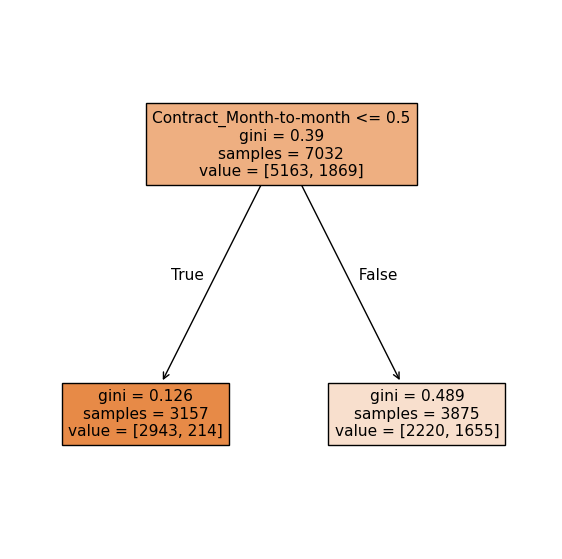

In [16]:
# Train two trees with different pruning strengths (alpha values)
tree_alpha_high = 0.05   # more pruning (simpler tree)

# impurity criterion is gini by default
# we can optionally pass arguments to enable Pre-Pruning
# e.g. max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes,
#      min_impurity_decrease
tree_model_simple = tree.DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    ccp_alpha=tree_alpha_high,
    criterion="gini"
)

# Note, there is a lot going on behind the scenes here fitting is a complex
# process the first argument is a dataset of the predictors. the second is a
# series of the target or y variable.
tree_model_simple.fit(X_encoded, y)

# Visualize the tree
fig = plt.figure(figsize=(7,7))
_ = tree.plot_tree(tree_model_simple,
                   feature_names=X_encoded.columns.to_list(), # make sure the feature names are in output
                   filled=True) # filled true color codes by the class. shading indicates proportion or quality of split

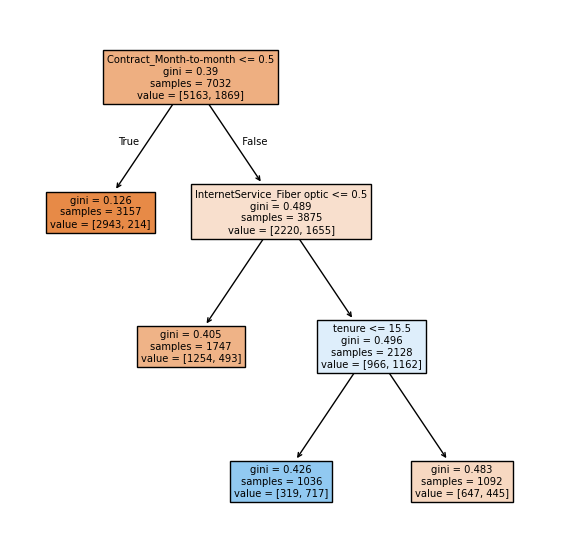

In [17]:
# Now we build a slightly more complex tree by reducing the complexity penalty
tree_alpha_low  = 0.01   # less pruning (more complex tree)

tree_model_complex = tree.DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    ccp_alpha=tree_alpha_low,

)
tree_model_complex.fit(X_encoded, y)
fig = plt.figure(figsize=(7,7))
_ = tree.plot_tree(tree_model_complex,
                   feature_names=X_encoded.columns.to_list(), # make sure the feature names are in output
                   filled=True) # filled true color codes by the class. shading indicates proportion or quality of split


# Part D — Cost-complexity pruning path

The pruning path starts with `ccp_alpha` of 0 (full build-out), and then progressively prunes this tree by increasing `ccp_alpha`. The path summary is the list of all "interesting" `ccp_alpha` (where some additional pruning occurs).

We will:
1. Compute the pruning path
2. Plot impurity vs alpha
3. Train a tree for each alpha
4. Plot complexity (depth/nodes) vs alpha

In [18]:
# Compute cost-complexity pruning path on the full dataset
# Just one command it all!
path = tree.DecisionTreeClassifier(random_state=RANDOM_STATE).cost_complexity_pruning_path(X_encoded, y)

# list of interesting alphas
ccp_alphas = path.ccp_alphas
# impurity of the trees (default is "gini" since we did not pass a different
# argument above)
impurities = path.impurities

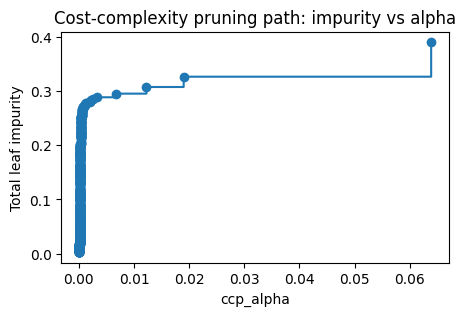

In [19]:
# Plot total leaf impurity vs alpha (steps-post is common for pruning paths)
fig = plt.figure(figsize=(5,3))
plt.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Total leaf impurity")
plt.title("Cost-complexity pruning path: impurity vs alpha")
plt.show()

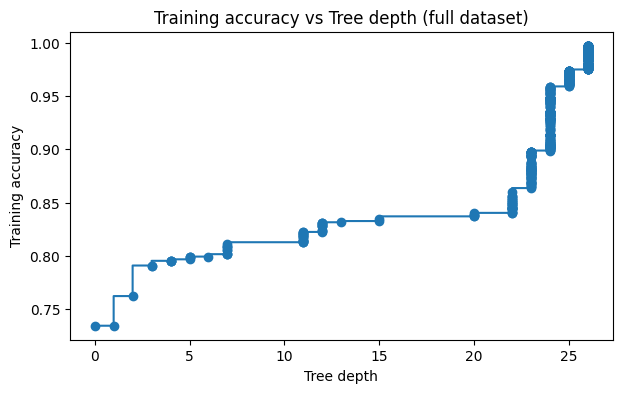

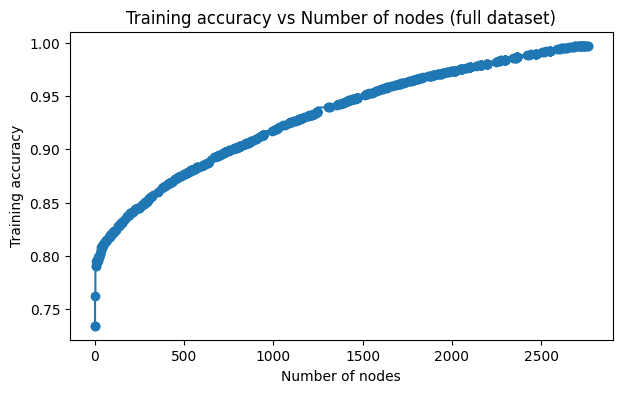

In [20]:
# Train and store a classifier for each alpha in ccp_alphas
clfs = []
for alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=alpha)
    clf.fit(X_encoded, y)
    clfs.append(clf)

# Collect complexity measures
node_counts = [clf.tree_.node_count for clf in clfs]
depths = [clf.tree_.max_depth for clf in clfs]
train_scores = [clf.score(X_encoded, y) for clf in clfs]

# Plot complexity vs training accuracy
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(depths, train_scores, marker="o", drawstyle="steps-post")
ax.set_xlabel("Tree depth")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy vs Tree depth (full dataset)")
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(node_counts, train_scores, marker="o", drawstyle="steps-post")
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy vs Number of nodes (full dataset)")
plt.show()

# Part E — Overfitting demo with a train/test split

We care about performance on **future unseen customers** (population/generalization), not performance on the training sample.

If we evaluate on the same data we trained on, performance is usually **too optimistic**.

We will:
1. Split our data into train and test sets
2. Compute pruning path and corresponding classifier trees on the training set
3. Plot **train vs test** accuracy to show overfitting

In [21]:
# Train/test split
# Saving 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y  # keep class balance similar in train and test
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
# The following command shows that the splitting preserved class balance across
# test and train splits
print("Train churn rate:", y_train.mean(), "| Test churn rate:", y_test.mean())

Train shape: (4922, 46) | Test shape: (2110, 46)
Train churn rate: 0.2657456318569687 | Test churn rate: 0.26587677725118486


In [22]:
# Pruning path computed on TRAINING data only
path = tree.DecisionTreeClassifier(random_state=RANDOM_STATE).cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas

# Train a classifier for each alpha, then score on train and test
clfs = []
train_scores = []
test_scores = []

for alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    # Find training accuracy (this is optimistic version of population accuracy)
    train_scores.append(clf.score(X_train, y_train))
    # Find test accuracy (this is an unbiased estimate of population accuracy)
    test_scores.append(clf.score(X_test, y_test))

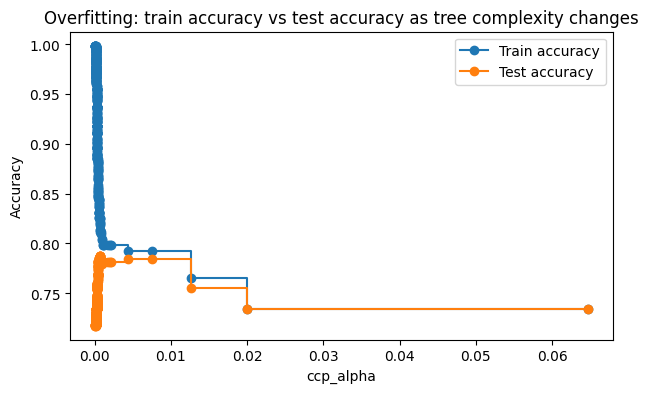

In [23]:
# Plot train vs test accuracy across alphas
fig = plt.figure(figsize=(7, 4))
plt.plot(ccp_alphas, train_scores, marker="o", label="Train accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores,  marker="o", label="Test accuracy",  drawstyle="steps-post")

plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Overfitting: train accuracy vs test accuracy as tree complexity changes")
plt.legend()
plt.show()

> **Important caution:**  
> In real projects, we do **not** choose hyperparameters (`ccp_alpha` in this case) using the test set.
> We will see how to use cross-validation for model selection later in this course, and reserve the test set for a final “one-time” evaluation.

# Summary / takeaway

- Decision trees can fit complex patterns, but they can also **overfit**.
- Cost-complexity pruning (`ccp_alpha`) gives a principled way to control tree complexity.
- Always keep **evaluation on unseen data** (test set) separate from training.
- Later in the course we will see:
  - Use a **validation set / cross-validation** to choose `ccp_alpha` properly.
  - Compare a single tree to ensembles (Random Forest, Gradient Boosting).